In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import numpy as np
!pip install -U keras
!pip install tensorflow-gpu==2.1.0rc0

!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
     |████████████████████████████████| 402.3MB 35kB/s 
     |████████████████████████████████| 450kB 57.8MB/s 
     |████████████████████████████████| 3.8MB 53.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a5171cdec8a9f908a588a153cb6089db88421389fd6387aed5f4b8718cbd783a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc4 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast

Using TensorFlow backend.


In [0]:
def convertToLabels(data):
  data[data==85]=1
  data[data==170]=2
  data[data==255]=3

def convertFromLabels(data):
  data[data==1]=85
  data[data==2]=170
  data[data==3]=255

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class PR"

Train = ['263', '232', '242', '230']
Test  = ['221', '246', '239', '252', '229']

# Train set patients: 230 232 239 242 
TrainX_1 = np.load(PATH + '/PR IHC 263 Images.npy')
TrainY_1 = np.load(PATH + '/PR IHC 263 Masks.npy')
TrainX_2 = np.load(PATH + '/PR IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/PR IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/PR IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/PR IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/PR IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/PR IHC 230 Masks.npy')

# Test set patients: 221 246 263
TestX_1 = np.load(PATH + '/PR IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/PR IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/PR IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/PR IHC 246 Masks.npy')
TestX_3 = np.load(PATH + '/PR IHC 239 Images.npy')
TestY_3 = np.load(PATH + '/PR IHC 239 Masks.npy')
TestX_4 = np.load(PATH + '/PR IHC 252 Images.npy')
TestY_4 = np.load(PATH + '/PR IHC 252 Masks.npy')
TestX_5 = np.load(PATH + '/PR IHC 229 Images.npy')
TestY_5 = np.load(PATH + '/PR IHC 229 Masks.npy')

In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGT = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = np.copy(TrainGT)
convertToLabels(TrainY)
TrainY = keras.utils.to_categorical(TrainY,num_classes=4,dtype='int16')

TestX = np.concatenate((TestX_1, TestX_2, TestX_3, TestX_4, TestX_5), axis=0)
TestGT = np.concatenate((TestY_1, TestY_2, TestY_3,TestY_4, TestY_5), axis=0)
TestY = np.copy(TestGT)
convertToLabels(TestY)
TestY = keras.utils.to_categorical(TestY,num_classes=4, dtype='int16')

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

In [0]:
TrainX = TrainX.astype('float32')/255
TestX = TestX.astype('float32')/255
ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(2400, 240, 240, 3)
(2400, 240, 240, 4)
(312, 240, 240, 3)
(312, 240, 240, 4)


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model():    
    input_layer = Input(shape=(240,240,3))
    block1 = get_conv_block(input_layer,32,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    mp1_pool = MaxPooling2D(pool_size=(2, 2))(mp1)
    mp1_pool_pool = MaxPooling2D(pool_size=(2, 2))(mp1_pool)
    mp1_pool_pool_pool = MaxPooling2D(pool_size=(2, 2))(mp1_pool_pool)
   
    block2 = get_conv_block(dr1,64,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    mp2_pool = MaxPooling2D(pool_size=(2, 2))(mp2)
    mp2_pool_pool = MaxPooling2D(pool_size=(2, 2))(mp2_pool)

    block3 = get_conv_block(dr2,128,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    mp3_pool = MaxPooling2D(pool_size=(2, 2))(mp3)
    
    block4 = get_conv_block(dr3,256,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(256,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4, up1, mp3])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,256,3)

    up2 = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    b4_upsample = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block4)
    cat2 = concatenate([block3, up2, b4_upsample, mp2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,128,3)
    
    up3 = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    b3_upsample = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block3)
    cat3 = concatenate([block2, up3, mp1, b3_upsample])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,64,3)
    
    up4 = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    b2_upsample = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block2)
    cat4 = concatenate([block1, up4, b2_upsample])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,64,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same')(conv10)

    model = Model(input_layer,conv11)
    return model

In [0]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(1.5*tversky_loss(y_true, y_pred))

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)

In [0]:
import random
batch_size = 16
def get_batch(batch_size, X_train, Y_train): 
    size_batch = batch_size
    last_index = len(X_train) - 1
    x_train = X_train
    y_train = Y_train 
    while True:
        batch_data = [[],[]]
        for i in range(0, size_batch):
            random_index = random.randint(0, last_index)
            batch_data[0].append(x_train[random_index])
            batch_data[1].append(y_train[random_index])

        yield (np.array(batch_data[0]), np.array(batch_data[1]))     
        
datagen = get_batch(batch_size, TrainX, TrainY)

In [0]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer= optimizer , metrics=[dice_coef,'accuracy'])

In [0]:
from math import ceil
num_epoch = 100
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR"
n_points = len(TrainX)
history = model.fit(datagen, 
                validation_data = (ValidX, ValidY),
                epochs=num_epoch,steps_per_epoch = ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
model.save(MODELS_PATH + '/4 Class_UNET_PR_7_05_2020 - v2.h5')

Epoch 1/100
113/113 [==============================] - 66s 583ms/step - loss: 6.6011 - dice_coef: 0.2652 - accuracy: 0.8041 - val_loss: 6.5189 - val_dice_coef: 0.2934 - val_accuracy: 0.9898

Epoch 00001: val_loss improved from inf to 6.51892, saving model to Checkpoint.h5
Epoch 2/100
113/113 [==============================] - 52s 464ms/step - loss: 6.2947 - dice_coef: 0.3180 - accuracy: 0.9650 - val_loss: 6.2882 - val_dice_coef: 0.3406 - val_accuracy: 0.9902

Epoch 00002: val_loss improved from 6.51892 to 6.28818, saving model to Checkpoint.h5
Epoch 3/100
113/113 [==============================] - 52s 464ms/step - loss: 6.0753 - dice_coef: 0.3635 - accuracy: 0.9643 - val_loss: 6.0636 - val_dice_coef: 0.3905 - val_accuracy: 0.9915

Epoch 00003: val_loss improved from 6.28818 to 6.06363, saving model to Checkpoint.h5
Epoch 4/100
113/113 [==============================] - 52s 464ms/step - loss: 5.8605 - dice_coef: 0.4125 - accuracy: 0.9675 - val_loss: 5.8707 - val_dice_coef: 0.4407 - val_

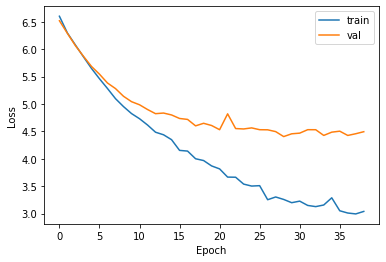

In [0]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

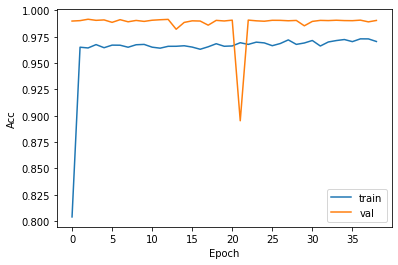

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
# MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/ER"
# model = keras.models.load_model(MODELS_PATH+'/4 Class_UNET_ER_12_04_2020.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
TrainX = np.concatenate((TrainX,ValidX))
TrainY = np.concatenate((TrainY,ValidY))
train_result = model.predict(TrainX, batch_size=16)
print(np.shape(train_result))
train_result = np.argmax(train_result, axis = 3)
print(np.shape(train_result))
convertFromLabels(train_result)
print(np.shape(train_result)

(2112, 240, 240, 4)
(2112, 240, 240)
(2112, 240, 240)


In [0]:
test_result = model.predict(TestX, batch_size=16)
print(np.shape(test_result))
test_result = np.argmax(test_result, axis = 3)
print(np.shape(test_result))
convertFromLabels(test_result)
print(np.shape(test_result))

(2400, 240, 240, 4)
(2400, 240, 240)
(2400, 240, 240)


In [0]:
copy1  = np.copy(TestX [250])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[250]

Predicted_Mask = Predicted_images_test[250] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:
def saveNumpyOutput(mask, Patient_array):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id*10, id*10+10):
      print(i)
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/PR/UNET/4 Class/High Twersky/" + Patient_array[id], final_output)

In [0]:
# saving predicted outputs as numpy arrays for test images
saveNumpyOutput(train_result, Train)
saveNumpyOutput(test_result, Test)

In [0]:
!ls "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/ER/UNET/4 Class/05-05-2020/"

(48, 240, 240)
(48, 240, 240, 3)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


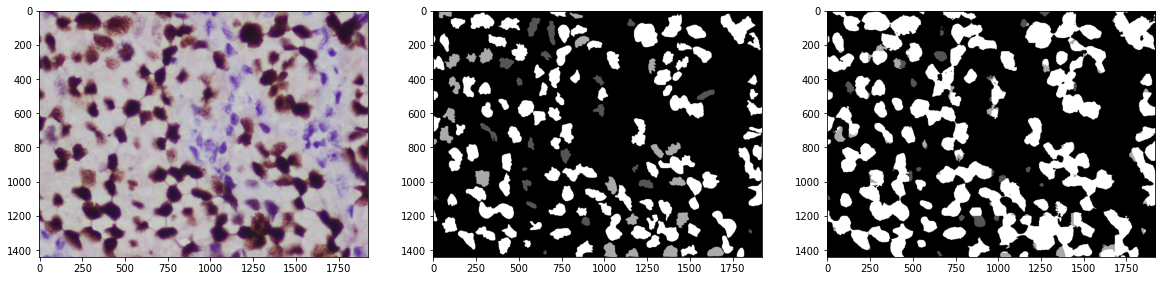

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 24   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Mask_input = np.argmax(Mask_input, axis = 3)
convertFromLabels(Mask_input)
print(Mask_input.shape)
print(final_input.shape)
final_output = test_result[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

(48, 240, 240)
(48, 240, 240, 3)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


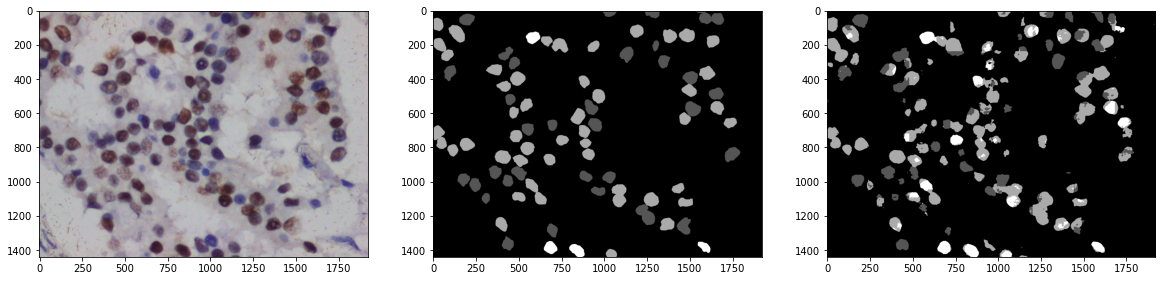

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 2  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]

Mask_input = np.argmax(Mask_input, axis = 3)
convertFromLabels(Mask_input)
print(Mask_input.shape)
print(final_input.shape)
final_output = train_result[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

In [0]:
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Predicted Images/PR/UNET/4 Class/High Twersky/Train/08-05-2020"
def saveImageOutput(patients, GroundTruth, Predicted):
  totalimages = patients * 10
  for id in range(totalimages):
    index = id * 48
    Mask_input = GroundTruth[index:index+48]
    Mask_input = np.argmax(Mask_input, axis = 3)
    convertFromLabels(Mask_input)
    final_output = Predicted[index:index+48]
    Mask_input   = stitchMaskPatches(Mask_input)
    final_output = stitchMaskPatches(final_output)
    cv2.imwrite(SAVE_PATH + '/Ground Truth/Image '+ str(id) + '.png', Mask_input)
    cv2.imwrite(SAVE_PATH +  '/Predicted Mask/Image '+ str(id) + '.png', final_output)

In [0]:
# saveImageOutput(5, TestY, test_result)
saveImageOutput(4, TrainY, train_result)